# Distinguishing Constant Stars

In timeseries photometry, we can define a constant star as one that shows no dicernable signal or trend in its lightcurve. 
However, real measurements are subject to statistical noise and therefore will always show some scatter, even if the star does not exhibit any astrophysical variation.  This is illustrated in the simulated example lightcurve below. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from romerea_toolkit import crossmatch,hd5_utils 

In [2]:
nepochs = 50
tstart = 60000.0
mean_mag = 16.0
scatter = 0.02
mjd = np.arange(tstart, tstart+nepochs, 1.0)
mag = np.random.normal(mean_mag, scale=scatter, size=nepochs)
mag_err = np.abs(scatter + np.exp(mag/-2.5))

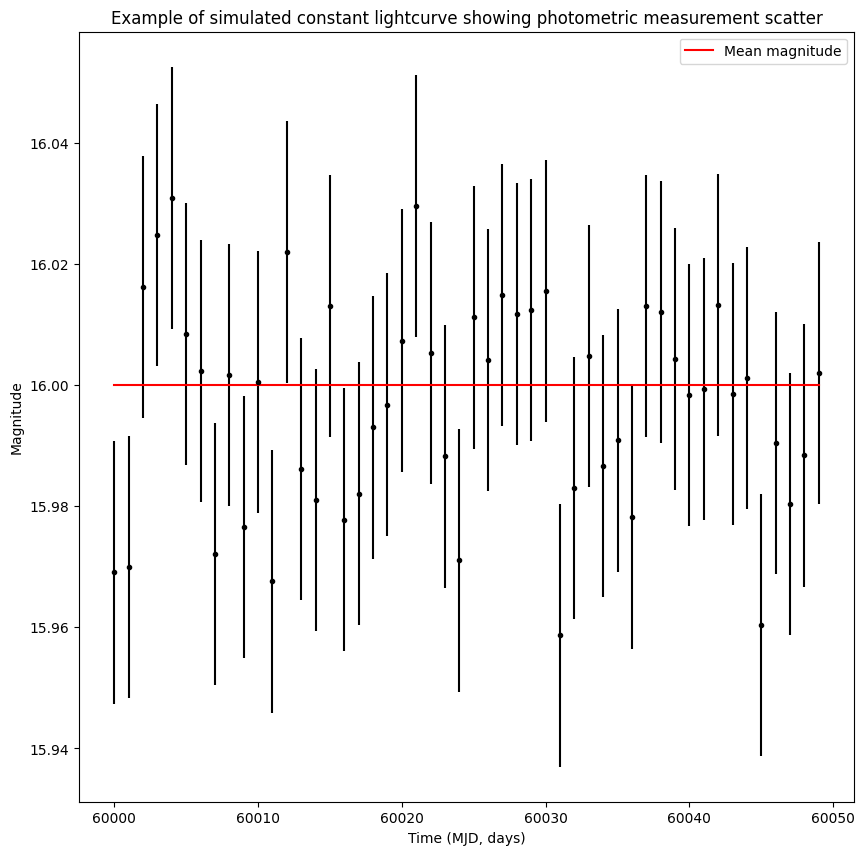

In [3]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.errorbar(mjd, mag, yerr=mag_err, c='black', marker='.', ls='none')
ax.plot(mjd, [mean_mag]*len(mjd), 'r-', label='Mean magnitude')
ax.set_xlabel('Time (MJD, days)')
ax.set_ylabel('Magnitude')
ax.set_title('Example of simulated constant lightcurve showing photometric measurement scatter')
ax.legend()

The vertical lines on the datapoints in the plot above represent the photometric uncertainties, or the precision to which each magnitude measurement has been made.  

For a constant star, and assuming that the noise in the data can be represented by a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution), then although the magnitude measurements may differ somewhat (scatter) from a constant, mean magnitude, they should be evenly distributed above and below this line.  If the uncertainties are estimated properly they should behave in a way consistant with a Gaussian distribution, i.e. 34.1% of the points should lie within 1sigma of the mean, where sigma is the Standard Deviation of the distribution.  

We can use this property to distinguish constant stars from those that show astrophysical variability.  

In [4]:
# Calculate the standard deviation of the constant lightcurve using Numpy's built-in methods. 
std_dev = mag.std()
print('Standard deviation of lightcurve = ' + str(round(std_dev,3)) + ' mag')

# This can be compared with the median measurement uncertainty, which represents the noise in the measurements.
med_error = np.median(mag_err)
print('Median measurement uncertainty = ' + str(round(med_error, 3)) + ' mag')

Standard deviation of lightcurve = 0.018 mag
Median measurement uncertainty = 0.022 mag


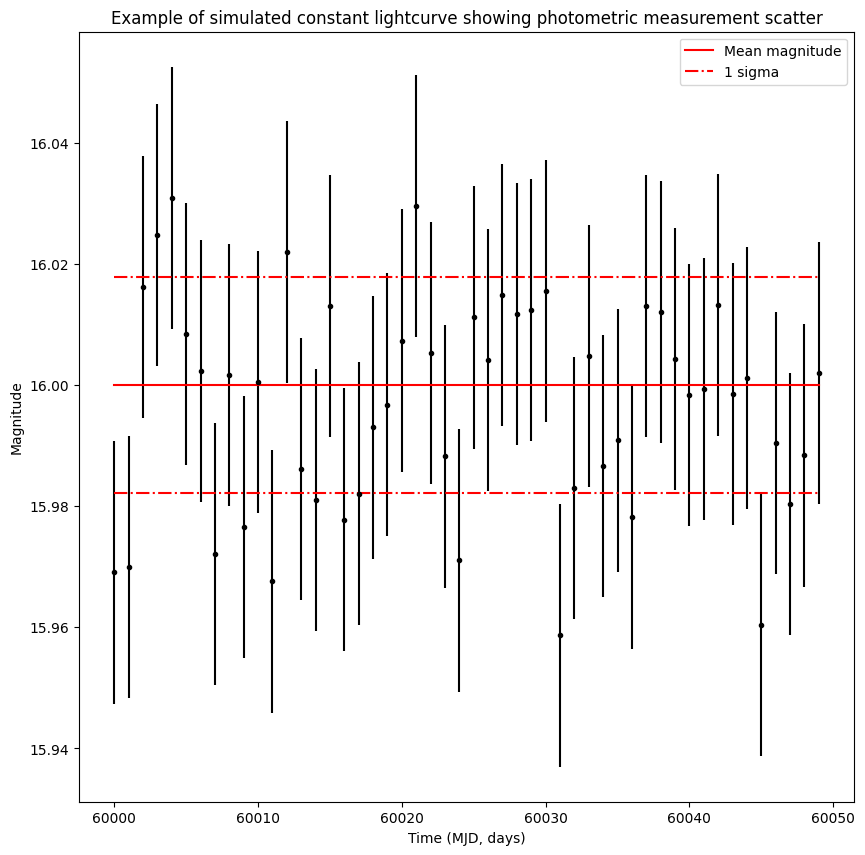

In [5]:
# Let's illustrate this STD with respect to the lightcurve 
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.errorbar(mjd, mag, yerr=mag_err, c='black', marker='.', ls='none')
ax.plot(mjd, [mean_mag]*len(mjd), 'r-', label='Mean magnitude')
ax.plot(mjd, [mean_mag-std_dev]*len(mjd), 'r-.', label='1 sigma')
ax.plot(mjd, [mean_mag+std_dev]*len(mjd), 'r-.')
ax.set_xlabel('Time (MJD, days)')
ax.set_ylabel('Magnitude')
ax.set_title('Example of simulated constant lightcurve showing photometric measurement scatter')
ax.legend()

For comparison, let's simulate a variable star.  In this lightcurve we have a true signal - the astrophysical phenomenon causing the photometric variation - but we also still have scatter due to real-world measurement noise.  

In [6]:
# Variable star photometry 
# Note that we are copying the arrays for the constant star for simplicity, and keeping the same measurement uncertainties.  This is 
# an approximation, but it is sufficient for our current purposes.  
# In particular, it means that the measurement noise or scatter in the data will still be the same as it was for the constant example. 
mjd2 = copy.deepcopy(mjd)
mag2 = copy.deepcopy(mag)
mag_err2 = copy.deepcopy(mag_err)
mean_mag2 = copy.deepcopy(mean_mag)
std_dev2 = copy.deepcopy(std_dev)

# Now we can inject a variable signal into this lightcurve
amplitude = 0.3
mag2 += amplitude * np.sin(mjd2)

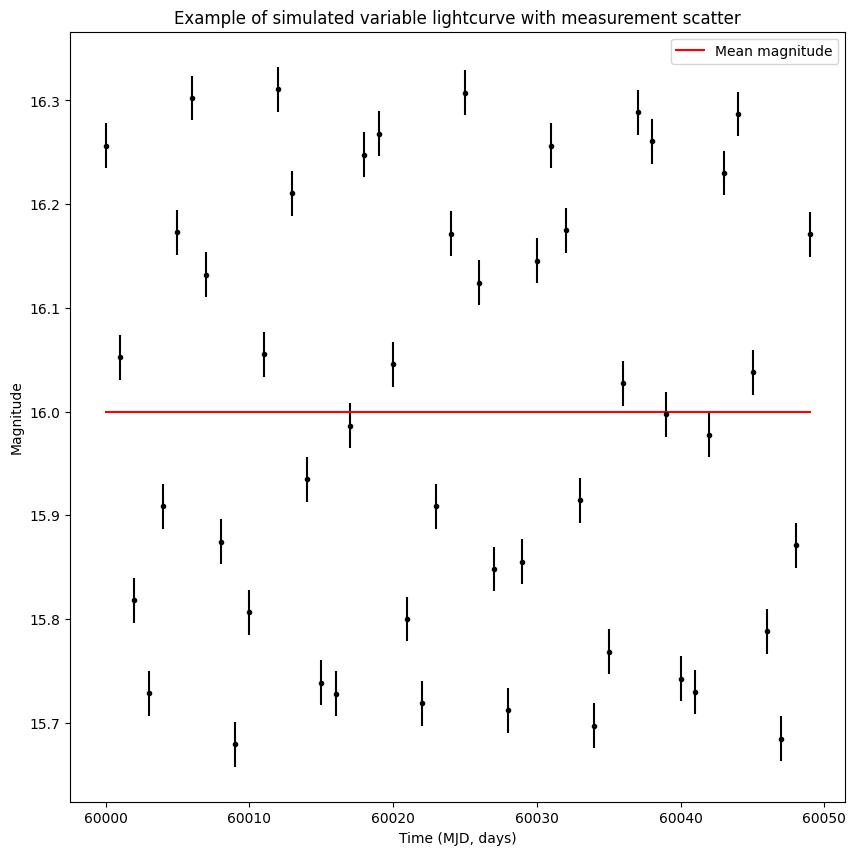

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.errorbar(mjd2, mag2, yerr=mag_err2, c='black', marker='.', ls='none')
ax.plot(mjd, [mean_mag2]*len(mjd2), 'r-', label='Mean magnitude')
ax.set_xlabel('Time (MJD, days)')
ax.set_ylabel('Magnitude')
ax.set_title('Example of simulated variable lightcurve with measurement scatter')
ax.legend()

This lightcurve clearly shows datapoints with large scatter from the mean magnitude, and the magnitude difference of most points from the mean far exceeds the measurement errors.  We can quantify this by once again comparing the standard deviation of the whole lightcurve with the median measurement error:

In [8]:
std_dev2 = mag2.std()
print('Standard deviation of lightcurve = ' + str(round(std_dev2, 3)) + ' mag')
med_error2 = np.median(mag_err2)
print('Median measurement uncertainty = ' + str(round(med_error2, 3)) + ' mag')

Standard deviation of lightcurve = 0.209 mag
Median measurement uncertainty = 0.022 mag


The standard deviation for a variable star is clearly much higher!  So comparing these two metrics is a useful way of distinguishing constant and variable stars.  

Of course, in real-world data, not all variable stars have as great an amplitude (maximum - minimum magnitude range) as this example.  In addition, as stars get fainter, they become harder to measure, so the noise in our measurements becomes greater.  

## Calculating lightcurve noise properties using ROME datacubes

To identify which stars are constant in the ROME photometry, we need to calculate the standard deviation for a large set of lightcurves.  This is most easily accomplished by loading the photometry datacubes.  

In [10]:
# Load the crossmatch table for an example field
crossmatch_file_path = '/Users/rstreet/ROME/ROME-FIELD-01/DR1/ROME-FIELD-01_field_crossmatch.fits'
xmatch = crossmatch.CrossMatchTable()
xmatch.load(crossmatch_file_path, log=None)

In [11]:
# Load the timeseries datacube for one quadrant of this field
phot_file_path = '/Users/rstreet/ROME/ROME-FIELD-01/DR1/ROME-FIELD-01_quad1_photometry.hdf5'
phot_data = hd5_utils.read_phot_from_hd5_file(phot_file_path)

In [14]:
# The shape of this datacube is a 3D numpy array, with star index first, image index second and column index third.  
print(phot_data.shape)

# So we can select all of the timeseries measurements for a single star quite simply by slicing this array as follows:
istar = 1000
print(phot_data[istar, :, :])

# This produces a 2D array of all columns of photometry measurements for all images in the dataset.  
# Note that not all measurements were good ones, so not all entries are valid!

(101231, 2214, 17)
[[2.45864579e+06 2.10768837e+01 3.53327329e-02 ... 5.77252375e+02
  1.68687599e+02 0.00000000e+00]
 [2.45855288e+06 2.10288016e+01 2.72976131e-02 ... 5.77252375e+02
  1.68687599e+02 0.00000000e+00]
 [2.45864569e+06 2.11169097e+01 2.57822502e-02 ... 5.77252375e+02
  1.68687599e+02 0.00000000e+00]
 ...
 [2.45833435e+06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.45836622e+06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.45839223e+06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


The datacubes contain the photometry for all images taken by the survey, but different filters were used for different images.  Since stars can have quite different magnitudes in different filter passbands, it doesn't make much sense for us to calculate the lightcurve mean magnitude using data from all images together - instead we need to use the crossmatch table to identify which images were taken in which filter.  Let's pick the 'rp' filter for example. 

In [24]:
# Show the (truncated) xmatch images table
print(xmatch.images)

# This has quite a lot of columns! 
print(xmatch.images.colnames)

index               filename               ... warp_matrix_15 qc_flag
----- ------------------------------------ ... -------------- -------
    0 lsc1m005-fa15-20190610-0205-e91.fits ...            0.0       0
    1 lsc1m005-fa15-20190309-0220-e91.fits ...            0.0       0
    2 lsc1m005-fa15-20190610-0183-e91.fits ...            0.0       0
    3 lsc1m005-fa15-20190312-0280-e91.fits ...            0.0       0
    4 lsc1m005-fa15-20190612-0218-e91.fits ...            0.0       0
    5 lsc1m005-fa15-20190316-0251-e91.fits ...            0.0       0
    6 lsc1m005-fa15-20190618-0266-e91.fits ...            0.0       0
  ...                                  ... ...            ...     ...
 2207 cpt1m012-fl06-20180420-0175-e91.fits ...            0.0       0
 2208 cpt1m012-fl06-20180421-0257-e91.fits ...            0.0       0
 2209 cpt1m012-fl06-20180422-0156-e91.fits ...            0.0       0
 2210 cpt1m012-fl06-20180802-0048-e91.fits ...            0.0       0
 2211 cpt1m012-fl06-

In [25]:
# Use the xmatch.images table's filter column to find the image indices of the datapoints for a chosen filter 
use_filter = 'rp'   # Can be 'gp', 'rp', or 'ip'

idx = np.where(xmatch.images['filter'] == use_filter)[0] 
print('Images with these indicies were taken in filter ' + use_filter + ': ' + repr(idx))

Images with these indicies were taken in filter rp: array([ 345,  346,  347,  348,  349,  350,  351,  352,  353,  354,  355,
        356,  357,  358,  359,  360,  361,  362,  363,  364,  365,  366,
        367,  368,  369,  370,  371,  372,  373,  374,  375,  376,  377,
        378,  379,  380,  381,  382,  383,  384,  385,  386,  387,  388,
        389,  390,  391,  392,  393,  394,  395,  396,  397,  398,  399,
        400,  401,  402,  403,  404,  405,  406,  407,  408,  409,  410,
        411,  412,  413,  414,  415,  416,  417,  418,  419,  420,  421,
        422,  423,  424,  425,  426,  427,  428,  429,  430,  431,  432,
        433,  434,  435,  436,  437,  438,  439,  440,  441,  442,  443,
        444,  445,  446,  447,  448,  449,  450,  451,  452,  453,  454,
        455,  456,  457,  458,  459,  460,  461,  462,  463,  464,  465,
        466,  467,  468,  469,  470,  471,  472,  473,  474,  475,  476,
        477,  478,  479,  480,  481,  482,  483,  484,  485,  486,  487,

Lastly we need to pick the relevant columns from all of the measurements produced by the pipeline.  
These are documented [here](https://github.com/rachel3834/romerea_toolkit).  
We need the timestamps (HJD=1st column) and the normalized magnitude and magnitude error measurements (8th and 9th columns). Don't forget Python numbers from zero though!  We also need the last column, which is a quality control flag (qc_flag).

So putting all this together, we can select the lightcurve for an example star:

In [33]:
star_lc = phot_data[istar, idx, :]
star_lc = star_lc[:, [0,7,8,16]]
star_lc

array([[2.45864470e+06, 1.99463892e+01, 5.88257485e-02, 0.00000000e+00],
       [2.45855287e+06, 1.99735920e+01, 6.59318247e-02, 0.00000000e+00],
       [2.45864263e+06, 1.99601980e+01, 6.81840228e-02, 0.00000000e+00],
       ...,
       [2.45835934e+06, 1.98846482e+01, 1.20612914e-01, 0.00000000e+00],
       [2.45836623e+06, 1.98385660e+01, 1.11507048e-01, 0.00000000e+00],
       [2.45839224e+06, 1.99137497e+01, 1.01232613e-01, 0.00000000e+00]])

We can now use the qc_flag to select only the valid measurements.  The flag value is zero if the pipeline considered the measurement to be sound.  It is also valuable to filter out zero measurements.  

In [40]:
jdx = np.where(star_lc[:,3] == 0.0)[0]
jdx2 = np.where(star_lc[:,2] != 0.0)[0]
valid = list(set(jdx).intersection(set(jdx2)))

We can now plot the example star lightcurve

Text(0.5, 1.0, 'Example of ROME star lightcurve in rp')

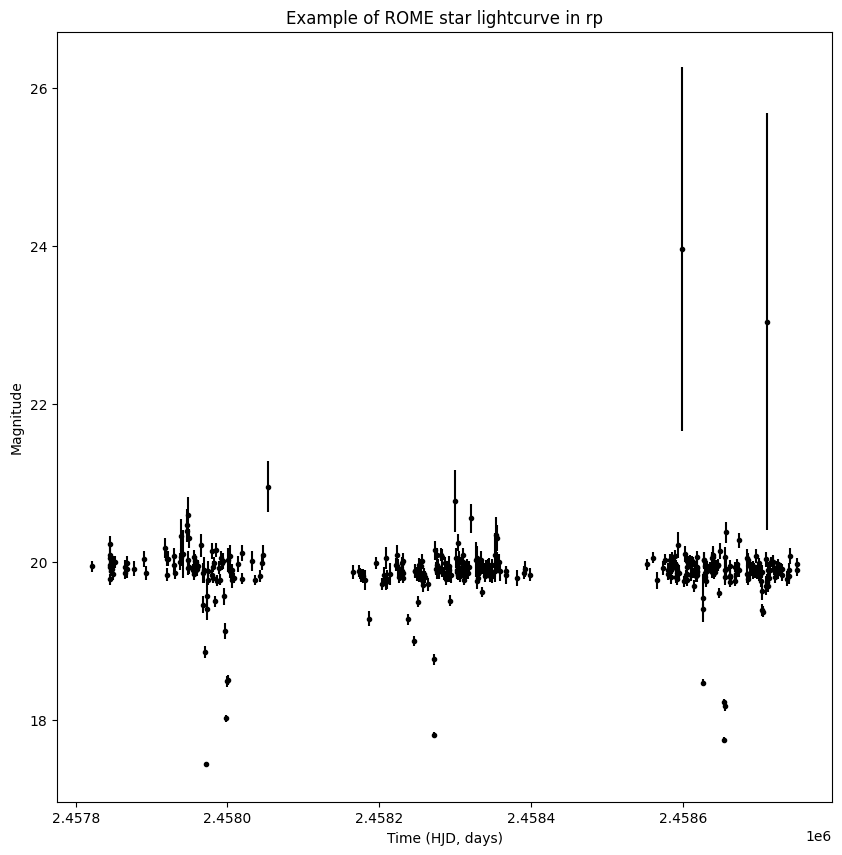

In [41]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.errorbar(star_lc[valid,0], star_lc[valid,1], yerr=star_lc[valid,2], c='black', marker='.', ls='none')
ax.set_xlabel('Time (HJD, days)')
ax.set_ylabel('Magnitude')
ax.set_title('Example of ROME star lightcurve in ' + use_filter)


As you can see, real-world data is always more messy that simulated data!  The pipeline's quality control doesn't necessarily pick up all data issues.  

With our lightcurve though, we can calculate the standard deviation and median photometric uncertainty as we did in the simulation. 

In [43]:
print('Example star median uncertainty = ' + str(np.median(star_lc[valid,2])) + ' mag')
print('Example star standard deviation = ' + str(star_lc[valid,1].std()) + ' mag')

Example star median uncertainty = 0.08090473588107679 mag
Example star standard deviation = 0.4359774448428975 mag


The last step is to make this calculation for all stars in the datacube, and plot the resulting median uncertainty and standard deviations.  This is most easily done using numpy array operations over the phot_data array.  